# Get MGRS Tiles for Habitat Data

Calculate MGRS tiles for habitat data and add to the DataFrame. Used to create coastline buffer in ArcGIS Pro.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [2]:
import geopandas as gpd
import contextily as cx

In [3]:
import mgrs

In [4]:
from shapely.geometry import MultiPolygon

In [5]:
import shapely.wkt

In [6]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

## Load habitat data

### OSPAR Habitats 2022

In [7]:
ospar_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_clustered/OSPAR2022Points.shp')

In [8]:
gdf = gpd.read_file(ospar_shp)

In [9]:
gdf.head()

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,Accuracy,Latitude,Longitude,AltHabType,AltHabClas,AltHabRel,SurveyDate,SurveyYear,Cluster,geometry
0,OSPARHab2010IE1v0,10100105,Zostera beds,Unknown,Present,None,None,None,2003-07-01,2003-10-31,...,None,55.045203,-7.125105,None,None,None,2003-10-31,2003,1661,POINT (-7.12511 55.0452)
1,OSPARHab2010IE1v0,10100039,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-08-01,None,1996-05-01,1996-12-31,...,None,52.669012,-9.569316,None,None,None,1996-12-31,1996,1662,POINT (-9.56932 52.66901)
2,OSPARHab2010IE1v0,10100020,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-03,None,1996-05-01,1996-12-31,...,None,52.305249,-9.854169,None,None,None,1996-12-31,1996,1401,POINT (-9.85417 52.30525)
3,OSPARHab2010IE1v0,10100013,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-04,None,1996-05-01,1996-12-31,...,None,52.142788,-9.943158,None,None,None,1996-12-31,1996,1663,POINT (-9.94316 52.14279)
4,OSPARHab2010IE1v0,10100024,Zostera beds,Zostera marina beds,Present,JH Allen,2003-06-13,None,1996-05-01,1996-12-31,...,None,52.264474,-9.825030,None,None,None,1996-12-31,1996,1401,POINT (-9.82503 52.26447)


## UTM tiles

In [10]:
def latlon_to_mgrs_tile(lat, lon):
    try:
        m = mgrs.MGRS()
        mgrs_code = m.toMGRS(lat, lon, MGRSPrecision=2)
        tile = mgrs_code[:5]
        return tile
    except Exception as e:
        print(f'Error computing MGRS for point {lat}, {lon}')
        raise

In [11]:
gdf['utm_tile'] = gdf.apply(lambda row: latlon_to_mgrs_tile(row.geometry.y, row.geometry.x), axis=1)

In [12]:
gdf.head()

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,Latitude,Longitude,AltHabType,AltHabClas,AltHabRel,SurveyDate,SurveyYear,Cluster,geometry,utm_tile
0,OSPARHab2010IE1v0,10100105,Zostera beds,Unknown,Present,None,None,None,2003-07-01,2003-10-31,...,55.045203,-7.125105,None,None,None,2003-10-31,2003,1661,POINT (-7.12511 55.0452),29UPB
1,OSPARHab2010IE1v0,10100039,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-08-01,None,1996-05-01,1996-12-31,...,52.669012,-9.569316,None,None,None,1996-12-31,1996,1662,POINT (-9.56932 52.66901),29UMU
2,OSPARHab2010IE1v0,10100020,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-03,None,1996-05-01,1996-12-31,...,52.305249,-9.854169,None,None,None,1996-12-31,1996,1401,POINT (-9.85417 52.30525),29UMT
3,OSPARHab2010IE1v0,10100013,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-04,None,1996-05-01,1996-12-31,...,52.142788,-9.943158,None,None,None,1996-12-31,1996,1663,POINT (-9.94316 52.14279),29UMT
4,OSPARHab2010IE1v0,10100024,Zostera beds,Zostera marina beds,Present,JH Allen,2003-06-13,None,1996-05-01,1996-12-31,...,52.264474,-9.825030,None,None,None,1996-12-31,1996,1401,POINT (-9.82503 52.26447),29UMT


Save dataframe

In [13]:
save_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_clustered/OSPAR2022Points.shp')
gdf.to_file(save_shp)

## UTM year record

Subset to seagrass and kelp forests to ensure area of interest is coastal and focussed on these habitats.

In [17]:
gdf = gdf[((gdf['HabType'] == 'Zostera beds') | (gdf['HabType'] == 'Kelp forests'))]

In [18]:
utm = gdf['utm_tile'].unique()

utm_years = []

for u in utm:
    u_years = gdf['SurveyYear'][gdf['utm_tile'] == '30UUA'].unique()
    u_years_dicts = [{'utm_tile': u, 'SurveyYear': y} for y in u_years]
    utm_years.extend(u_years_dicts)

In [19]:
utm_year_df = pd.DataFrame.from_dict(utm_years)

In [20]:
utm_year_df

,utm_tile,SurveyYear
0,29UPB,2017
1,29UPB,1994
2,29UPB,2014
3,29UPB,2012
4,29UPB,2010
...,...,...
3385,31UCU,2020
3386,31UCU,1996
3387,31UCU,1986
3388,31UCU,1977


In [21]:
utm

array(['29UPB', '29UMU', '29UMT', '29UNA', '29UNT', '29UMV', '29UMA',
       '29UNB', '29UPT', '29UPV', '32VNK', '32VNL', '32VMK', '32VPK',
       '32VNR', '32VLP', '32VPL', '32VNM', '32VLQ', '32VPJ', '33VUC',
       '32VMH', '32VNJ', '32VMJ', '32VNH', '32UMG', '32UMH', '32UNF',
       '32VPH', '32UMF', '32UPG', '32UPH', '33UUC', '33UUB', '32UNG',
       '32UNH', '32UPF', '33UUA', '33UVB', '33UVA', '27WVM', '27WVN',
       '32UME', '32ULE', '31UET', '31UES', '31UFV', '30UXV', '30TXQ',
       '30TXP', '30UWV', '30TWT', '30UUU', '30UVV', '30UWU', '30UVU',
       '30TVT', '30TWS', '30TVU', '30UXA', '30VWJ', '30VVJ', '29VPC',
       '29VNC', '29VND', '28VEJ', '30VUH', '30VUJ', '29VPD', '30VWH',
       '30UUG', '30UUH', '30VXN', '30VWM', '30VXM', '30VWN', '29VPF',
       '30VUL', '30VVL', '30VWL', '29VNE', '29VPE', '30VUK', '30VVK',
       '30UWG', '30UVF', '30UWH', '30VVH', '30UUF', '30UWB', '30UVB',
       '30UXF', '29UPR', '30UUA', '30UUB', '30UTA', '30UVA', '30UWA',
       '30UXB', '30U

Save

In [22]:
utm_year_df.to_csv(os.path.join(DATA_DIR, 'utm_years.csv'))

## Coastline buffer

In [22]:
tileId = '30UUA'

In [23]:
wkt_fp = os.path.join(DATA_DIR, f'coastline_buffer/Buffered_Coastline_{tileId}.wkt')

In [24]:
with open(wkt_fp, 'r') as f:
    wkt = f.read()

In [27]:
wkt

'MULTIPOLYGON (((-4.262491104999981 50.156573791000028, -4.2467433429999346 50.159996539000076, -4.2342679959999714 50.16701220300007, -4.2267883589999542 50.176744770000028, -4.2257825649999745 50.187703620000036, -4.2316136339999275 50.198108923000063, -4.2421810609999397 50.205613802000073, -4.2569252079999274 50.210257554000066, -4.2737669219999361 50.21093746300005, -4.2895802259999414 50.207420892000073, -4.3024538419999772 50.199915198000042, -4.3094470499999602 50.190186672000038, -4.3101475449999498 50.179522629000076, -4.304765290999967 50.169731364000029, -4.2942538249999416 50.162096233000057, -4.2791531089999353 50.157294344000036, -4.262491104999981 50.156573791000028)), ((-4.859672724999939 50.561949650000031, -4.9081628299999807 50.561131659000068, -4.9215282409999759 50.559297442000059, -4.9368812279999474 50.560632067000029, -4.9502184349999538 50.558817059000035, -4.9603507229999764 50.555203277000032, -4.9688225029999558 50.549751799000035, -4.9805533709999281 50.53

In [30]:
geom = shapely.wkt.loads(wkt)

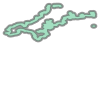

In [39]:
geom

In [49]:
simplified_poly = geom.simplify(tolerance=0.01, preserve_topology=True)

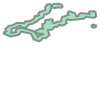

In [50]:
simplified_poly